# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import glob
import keras
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, ProgbarLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import F1Score, AUC
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet, EfficientNetV2B0, EfficientNetV2B2
import albumentations as A
from tensorflow.keras import layers

2024-07-02 19:35:31.809384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 19:35:31.809503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 19:35:31.941843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# GPU

In [2]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tue Jul  2 19:35:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Para descargar archivos de drive
!pip install gdown

In [4]:
# random seed
SEED = 1234
keras.utils.set_random_seed(SEED)

# Conjunto de datos

In [5]:
!gdown 1uSxokoiqyQkozyCNnjRL_htMdnDsnMxt # data part 1
!gdown 1fuaw9s7C3dIMjapxsLxGJFv4G1vGEuX- # data part 2
#from google.colab import drive
#drive.mount('/content/gdrive')

Downloading...
From (original): https://drive.google.com/uc?id=1uSxokoiqyQkozyCNnjRL_htMdnDsnMxt
From (redirected): https://drive.google.com/uc?id=1uSxokoiqyQkozyCNnjRL_htMdnDsnMxt&confirm=t&uuid=4a8aca1c-d9d0-4f3c-ba7b-895e24396efd
To: /kaggle/working/upch-intro-ml-001.zip
100%|██████████████████████████████████████| 2.16G/2.16G [00:27<00:00, 77.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fuaw9s7C3dIMjapxsLxGJFv4G1vGEuX-
From (redirected): https://drive.google.com/uc?id=1fuaw9s7C3dIMjapxsLxGJFv4G1vGEuX-&confirm=t&uuid=ca071dff-9e29-4339-86ef-87104acab791
To: /kaggle/working/upch-intro-ml-002.zip
100%|████████████████████████████████████████| 167M/167M [00:02<00:00, 64.7MB/s]


In [6]:
# Descomprimir data
!unzip -qq "/kaggle/working/upch-intro-ml-001.zip"
!unzip -qq "/kaggle/working/upch-intro-ml-002.zip"

In [7]:
DATASET_DIR = "/kaggle/working/upch-intro-ml"
TRAIN_CSV = os.path.join(DATASET_DIR, "train.csv")
TEST_CSV = os.path.join(DATASET_DIR, "test.csv")
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, "train/train")
TEST_IMG_DIR = os.path.join(DATASET_DIR, "test/test")

In [8]:
# Cargamos los archivos csv.
data_df = pd.read_csv(TRAIN_CSV)

In [9]:
# Añadir la extensión '.jpg' y la ubicación del ojo al nombre del archivo en el DataFrame
data_df['ID'] = data_df.apply(lambda row: f"{row['ID']}_{row['location']}.jpg", axis=1)

# Añadir ruta de carpeta con las imágenes
data_df['ID'] = data_df['ID'].apply(lambda filename: os.path.join(TRAIN_IMG_DIR, filename))

# Convertir clase a flotante
data_df['level'] = data_df['level'].values.astype(np.float32)
data_df.head()

,ID,location,level
0,/kaggle/working/upch-intro-ml/train/train/d3d9...,left,0.0
1,/kaggle/working/upch-intro-ml/train/train/d3d9...,right,0.0
2,/kaggle/working/upch-intro-ml/train/train/c51c...,left,0.0
3,/kaggle/working/upch-intro-ml/train/train/c51c...,right,0.0
4,/kaggle/working/upch-intro-ml/train/train/9bf3...,left,1.0


## Distribución de clases

In [10]:
data_df['level'].value_counts()

level
0.0    18057
1.0     6531
Name: count, dtype: int64

In [11]:
frecuencia_clases = data_df['level'].value_counts().to_dict()
print(frecuencia_clases)

{0.0: 18057, 1.0: 6531}


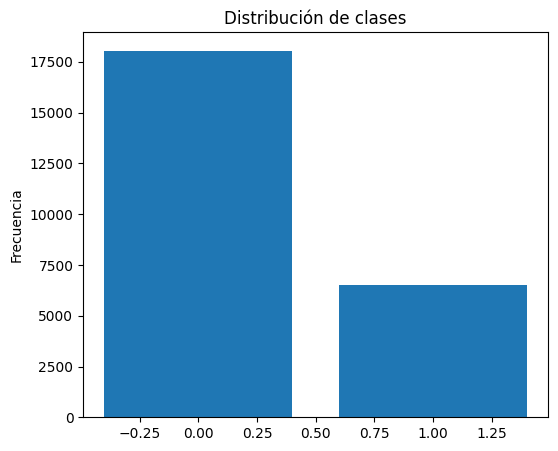

In [12]:
plt.figure(figsize=(6, 5))
plt.bar(list(frecuencia_clases.keys()), frecuencia_clases.values())
plt.title("Distribución de clases")
plt.ylabel('Frecuencia')
plt.show()

## Particionamiento de datos

In [13]:
# Dividir los datos en entrenamiento y validación
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=SEED, stratify=data_df['level'])

print(f'Tamaño de entrenamiento: {train_df.shape}')
print(f'Tamaño de validación: {val_df.shape}')

Tamaño de entrenamiento: (19670, 3)
Tamaño de validación: (4918, 3)


In [14]:
# Entrenamiento
print("Entrenamiento")
print(train_df['level'].value_counts())

# Validación
print("\nValidación")
print(val_df['level'].value_counts())

Entrenamiento
level
0.0    14445
1.0     5225
Name: count, dtype: int64

Validación
level
0.0    3612
1.0    1306
Name: count, dtype: int64


## Creación de dataset en tensorflow

In [15]:
IMG_SIZE = 224
INPUT_SIZE = (224, 224, 3)
print(f'Tamaño de imagen: {INPUT_SIZE}')

num_classes = 2
print(f'Número de classes: {num_classes}')

Tamaño de imagen: (224, 224, 3)
Número de classes: 2


In [16]:
def cargar_imagenes(ruta, etiqueta, img_size):
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)  # Leer la imagen 
    imagen = tf.image.resize(imagen, img_size[:-1])  # Ajustar el tamaño según sea necesario
    # Convertir a uint8
    imagen = tf.cast(imagen, tf.uint8)
    #etiqueta = tf.one_hot(etiqueta, depth=num_classes)
    return imagen, [etiqueta]

def aug_fn(imagen, img_size, transforms):
    data = {"image":imagen}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

def aumento_datos(imagen, etiqueta, img_size, transforms):
    imagen = tf.numpy_function(func=lambda x: aug_fn(x, img_size, transforms), inp=[imagen], Tout=tf.float32)
    imagen.set_shape(img_size)
    return imagen, etiqueta

def crear_dataset(imagenes_rutas, etiquetas, batch_size, input_shape, shuffle=True, buffer_size=1024, transforms=None):
    # Cargar imágenes
    dataset = tf.data.Dataset.from_tensor_slices((imagenes_rutas, etiquetas))
    #dataset = dataset.cache()
    
    # Mezclar datos
    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size)

    # Cargar datos
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.map(lambda x, y: cargar_imagenes(x, y, input_shape), num_parallel_calls=AUTOTUNE)

    # Aplicar transformaciones de preprocesamiento y aumento de datos
    if transforms is not None:
        dataset = dataset.map(lambda x, y: aumento_datos(x, y, img_size=input_shape, transforms=transforms), num_parallel_calls=AUTOTUNE)

    # Particionar data en lotes y uso de prefetch para acelerar el cargado de datos
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [17]:
train_transforms = A.Compose([
    A.CenterCrop(160, 160, p=1.0),
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=1, always_apply=True, p=1),
    A.RandomBrightnessContrast(brightness_limit=(0.1, 0.1), contrast_limit=(0.1, 0.1), p=1),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale =(0.5, 1.0) ,p=0.5),
])

val_transforms = A.Compose([
    A.CenterCrop(160, 160, p=1.0),
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=1, always_apply=True, p=1),
    A.RandomBrightnessContrast(brightness_limit=(0.1, 0.1), contrast_limit=(0.1, 0.1), p=1),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True),
])

# Ejemplo de cargado de datos
batch_size = 16
train_dataset = crear_dataset(train_df['ID'], train_df['level'], batch_size,
                                 INPUT_SIZE, shuffle=True, transforms=train_transforms, buffer_size=len(train_df))
val_dataset = crear_dataset(val_df['ID'], val_df['level'], batch_size,
                               INPUT_SIZE, shuffle=False, transforms=val_transforms)

## Lote aleatorio

In [18]:
imagen, etiquetas = next(iter(train_dataset))

print('Batch')
print('-'*6)
print(f'Tamaño de imagen: {imagen.shape}')
print(f'Tamaño de etiquetas: {etiquetas.shape}')

Batch
------
Tamaño de imagen: (16, 224, 224, 3)
Tamaño de etiquetas: (16, 1)


## Visualización de lote

In [19]:
def visualizar_imagenes(imagenes, etiquetas, transformaciones=None):
    fig = plt.figure(figsize=(15, 10))
    for i in range(len(imagenes)):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(imagenes[i]/255)
        ax.set_title(f"Etiqueta: {etiquetas[i][0]}")
    plt.tight_layout()
    plt.show()

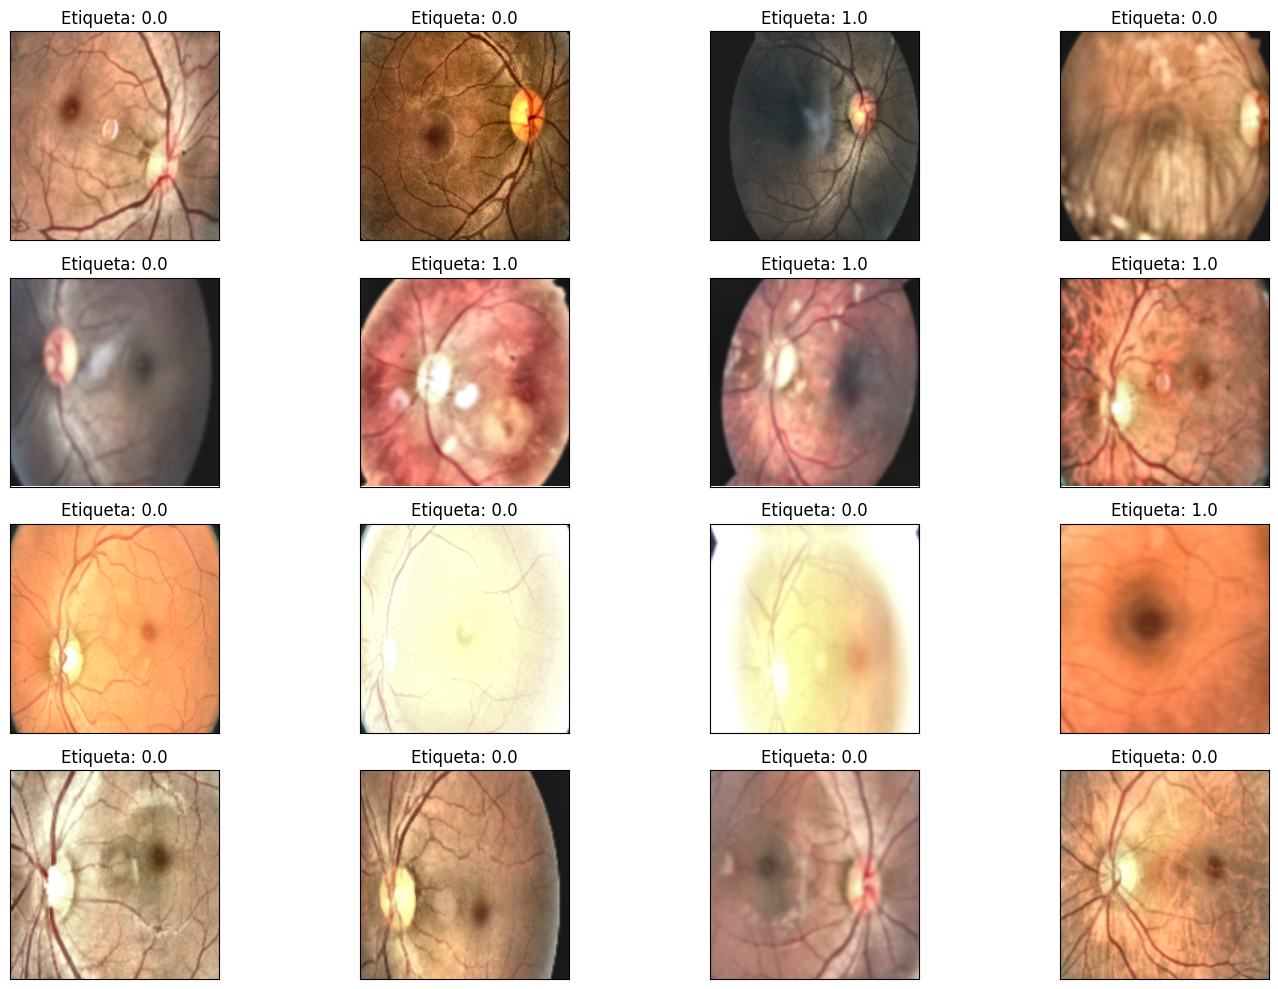

In [20]:
# Lote de entrenamiento
imagen, etiquetas = next(iter(train_dataset))
visualizar_imagenes(imagen, etiquetas)

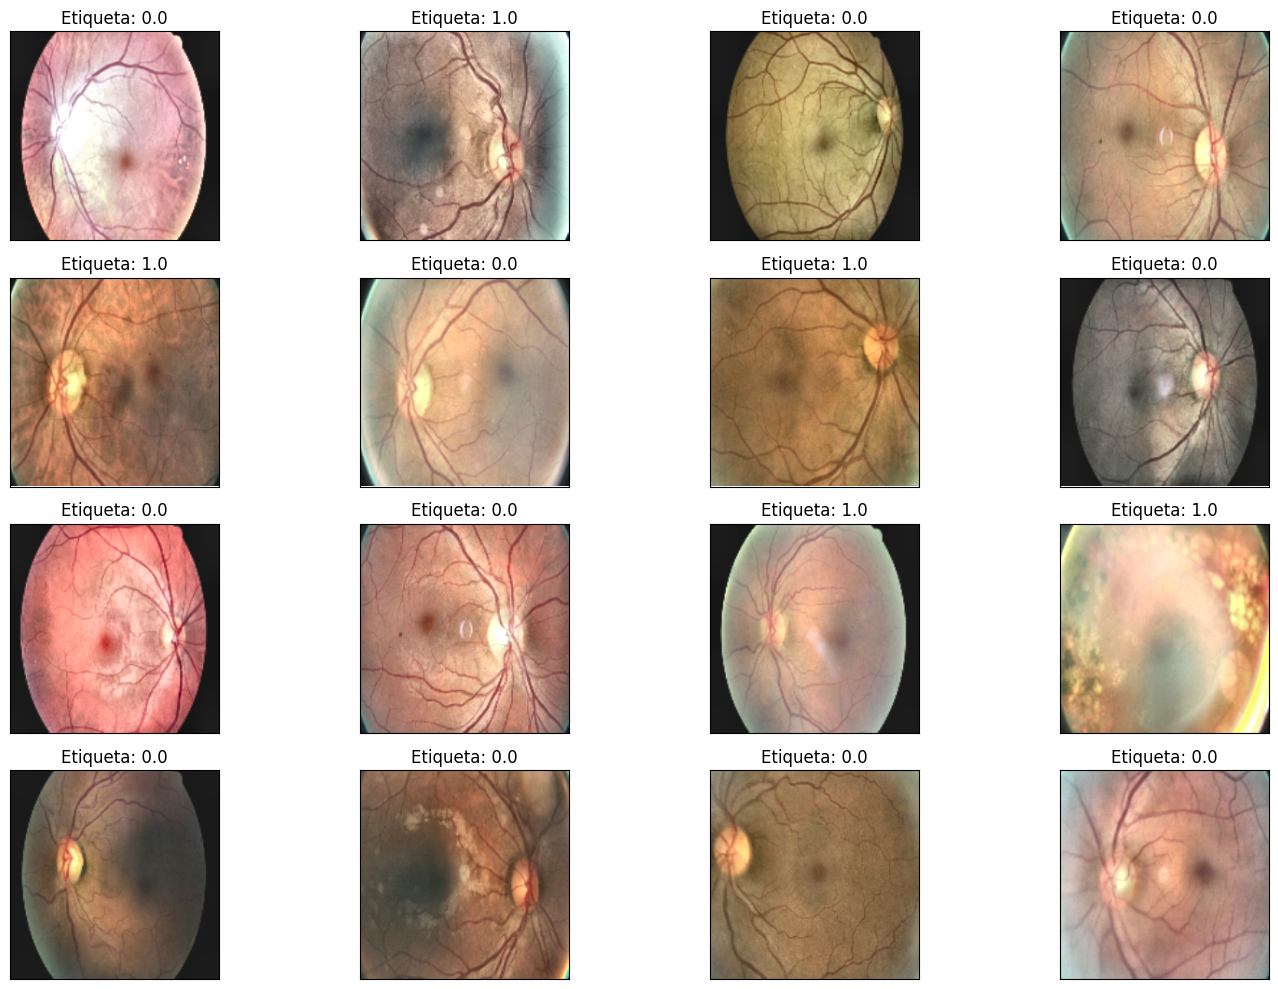

In [21]:
# Lote de validación
imagen, etiquetas = next(iter(val_dataset))
visualizar_imagenes(imagen, etiquetas)

## Balanceo de datos

In [22]:
numero_muestras = train_df.shape[0]
frecuencia_classes = train_df['level'].value_counts().to_dict()
print(f'Muestras de entrenamiento: {numero_muestras}')
print(f'Conteo de clases: {frecuencia_classes}')

Muestras de entrenamiento: 19670
Conteo de clases: {0.0: 14445, 1.0: 5225}


In [23]:
#cross entropy = -w1 * y1*logy1_pred - w2 * y2*logy2_pred - w3* y3*logy3_pred
def calcular_pesos_clases(train_df):
    numero_muestras = train_df.shape[0]
    frecuencia_classes = train_df['level'].value_counts().to_dict()
    pesos_clases = {}

    # Frecuencias inversas
    for etiqueta, conteo in frecuencia_classes.items():
        pesos_clases[int(etiqueta)] = numero_muestras /(conteo * num_classes)
    return pesos_clases

pesos_clases = calcular_pesos_clases(train_df)
print(f'Pesos de clases: {pesos_clases}')

Pesos de clases: {0: 0.68085842852198, 1: 1.8822966507177032}


## Modelo

In [24]:
def crear_modelo(input_shape, freeze_layers=False, train_from_layer=''):
    # Entrada
    input_tensor = Input(shape=input_shape)

    # Preprocesamiento de efficientNet
    input_tensor = tf.keras.applications.efficientnet_v2.preprocess_input(input_tensor)

    # Cargar modelo preentrenado
    base_model = EfficientNetV2B2(weights="imagenet", input_shape=input_shape, include_top=False)

    # Congelar capas
    if freeze_layers == True:
        trainable = False
        for layer in base_model.layers:
            if layer.name.startswith(train_from_layer) or train_from_layer in layer.name:
                trainable = True
            layer.trainable = trainable
    
    # Extraer características
    caracteristicas = base_model(input_tensor)

    # Añadir nuevas capas (clasificador)
    x = GlobalAveragePooling2D()(caracteristicas)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    return model

In [25]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = crear_modelo(input_shape, False)
model.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,770,783 (33.46 MB)

 Trainable params: 8,688,495 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

## Entrenamiento

In [26]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_f1_score', save_best_only=True, verbose=0, mode='max')
#progbar_logger = ProgbarLogger()  # Callback para mejorar la visualización del progreso

# Hiperparámetros
learning_rate = 1e-4
epochs = 10
batch_size = 32
freeze_layers = False

# Inicializar modelo
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = crear_modelo(input_shape, freeze_layers)

# Compilación del modelo para el calentamiento
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy', metrics=['accuracy', F1Score(threshold=0.5), AUC()])

# Conjuntos de datos
train_dataset = crear_dataset(train_df['ID'], train_df['level'], batch_size,
                             INPUT_SIZE, shuffle=True, transforms=train_transforms, buffer_size=len(train_df))
val_dataset = crear_dataset(val_df['ID'], val_df['level'], batch_size,
                            INPUT_SIZE, shuffle=False, transforms=val_transforms)


# Continuar entrenamiento en la fase de ajuste fino
train_result = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset,
                         callbacks=[early_stopping, reduce_lr, checkpoint], class_weight=pesos_clases)

Epoch 1/10


I0000 00:00:1719949200.372117      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


615/615 ━━━━━━━━━━━━━━━━━━━━ 481s 513ms/step - accuracy: 0.5815 - auc: 0.6144 - f1_score: 0.4245 - loss: 0.6695 - val_accuracy: 0.7044 - val_auc: 0.7496 - val_f1_score: 0.5298 - val_loss: 0.5917 - learning_rate: 1.0000e-04
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 182s 295ms/step - accuracy: 0.7161 - auc: 0.7456 - f1_score: 0.5328 - loss: 0.5841 - val_accuracy: 0.7412 - val_auc: 0.7896 - val_f1_score: 0.5786 - val_loss: 0.5544 - learning_rate: 1.0000e-04
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 182s 295ms/step - accuracy: 0.7302 - auc: 0.7706 - f1_score: 0.5599 - loss: 0.5638 - val_accuracy: 0.7883 - val_auc: 0.7986 - val_f1_score: 0.5988 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 184s 300ms/step - accuracy: 0.7552 - auc: 0.8005 - f1_score: 0.5967 - loss: 0.5361 - val_accuracy: 0.7694 - val_auc: 0.8072 - val_f1_score: 0.6015 - val_loss: 0.5064 - learning_rate: 1.0000e-04
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 185s 300ms/step - accuracy: 0.7672 

### Learning curves

In [27]:
def learning_curve(history, key='loss', title='Loss curve'):
    epochs = np.arange(1, len(history.history[key]) + 1)

    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history[key], label='Training')
    plt.plot(epochs, history.history['val_' + key], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.legend()

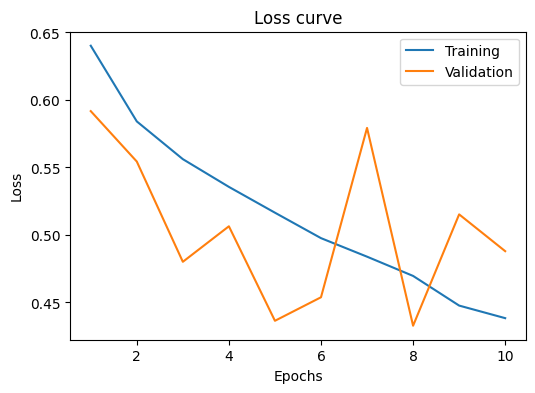

In [28]:
learning_curve(train_result, 'loss')

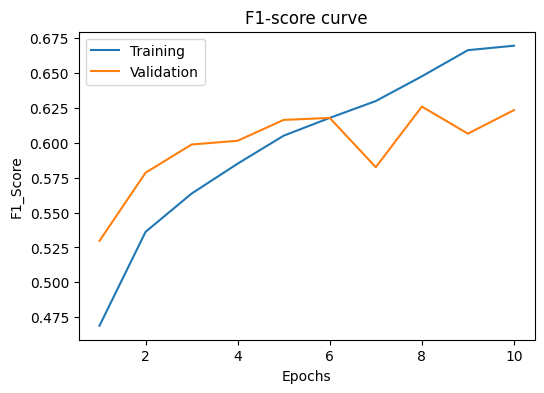

In [29]:
learning_curve(train_result, 'f1_score', 'F1-score curve')

In [30]:
learning_curve(train_result, 'auc_12', 'AUC curve')

KeyError: 'auc_12'

### Cargar mejor modelo

In [ ]:
checkpoint_filepath = 'best_model.keras'

# Cargar pesos del mejor modelo
model.load_weights(checkpoint_filepath)

## Resultados de validación

In [ ]:
# Obtener probabilidades de validación
probabilidades_val = model.predict(val_dataset)

In [ ]:
# Obtener predicciones
y_val_pred = (probabilidades_val > 0.5).astype(int)

### Métricas de clasificación

In [ ]:
from sklearn.metrics import classification_report
etiquetas_val = val_df['level'].values 
print(classification_report(etiquetas_val, y_val_pred))

### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def visualizar_matriz_confusion(etiquetas_reales, etiquetas_predichas, class_names, titulo='Matriz de confusión'):
    # Calcular matriz de confusión
    cm = confusion_matrix(etiquetas_reales, etiquetas_predichas)

    # Visualizar matriz de confusión
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(titulo)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

In [ ]:
class_names=['0', '1']
visualizar_matriz_confusion(etiquetas_val, y_val_pred, class_names, 'Matriz de confusión de validación')

## Resultados de la data de prueba

In [ ]:
!gdown 1dZ-Px4FOxGL5fv9T7q1yXW3RyRbbN4GJ #descargar sample.csv

In [ ]:
test_df_orig = pd.read_csv('sample.csv')
test_df_orig.head()

In [ ]:
test_df_orig.shape

In [ ]:
test_df = test_df_orig.copy()
# Añadir la extensión '.jpg' y la ubicación al nombre del archivo en el DataFrame
test_df['ID'] = test_df.apply(lambda row: os.path.join(TEST_IMG_DIR, f"{row['ID']}.jpg"), axis=1)
test_df.head()

### Cargar mejor modelo

In [ ]:
#!gdown 1t6Wl_TmLmG_GYiFllIEM9bpI23mgov-2 # Descargar mejor modelo

In [ ]:
## Hiperparámetros
#learning_rate = 1e-4
#epochs = 10
#batch_size = 32
#freeze_layers = False

# Inicializar modelo
#input_shape = (IMG_SIZE, IMG_SIZE, 3)
#model = crear_modelo(input_shape, freeze_layers)

# Cargar pesos del mejor modelo
#checkpoint_filepath = 'best_model.keras'
#model.load_weights(checkpoint_filepath)

### Crear dataset

In [ ]:
# Cargar data de prueba
test_dataset = crear_dataset(test_df['ID'], test_df['score'], batch_size,
                             INPUT_SIZE, shuffle=False, transforms=val_transforms)

### Predicciones

In [ ]:
# Predecir probabilidades
probabilidades_test = model.predict(test_dataset)

In [ ]:
# Predicciones
y_test_pred = (probabilidades_test > 0.5).astype(int)

### Crear CSV

In [ ]:
# Dataframe con resultados finales
test_df_final = test_df.copy() 

test_df_final['score'] = y_test_pred
test_df_final['ID'] = test_df_orig['ID']

test_df_final.head()

In [ ]:
# Crear DataFrame y guardar en CSV
df_results = pd.DataFrame(test_df_final, columns=['ID', 'score'])
df_results.to_csv('best_model_kaggle_efficientnetv2b2_randomcuts.csv', index=False)